<a href="https://colab.research.google.com/github/rballachay/homework/blob/main/COMP579/COMP579_A3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Get data to train

In [2]:
import requests 
import numpy as np

BASE='https://raw.githubusercontent.com/zhanwen-xin/actor-critic-random-cartpole-buffer/main/datasets/'

EXPERT_DATA={
    'ac':[100,250,500],
    'acrn':[100,250,500],
    'rn':[100,250,500]
}

FILE_TEMPLATE = "ds_{agent}_{neps}ep.json"

class DataLoader:
    def __init__(self, base_path=BASE, expert_data=EXPERT_DATA, \
                 template=FILE_TEMPLATE):
        self.base_path=base_path
        self.expert_data=expert_data
        self.template=template

    def load(self):
        for agent, eps_list in self.expert_data.items():
            for neps in eps_list:
                url = f"{BASE}{self.fstr(agent, neps)}"
                response = requests.get(url).json()

                # unpack response 
                states = np.array([item for sublist in response['states'] for item in sublist])
                actions = np.array([item for sublist in response['actions'] for item in sublist])
                rewards = np.array([item for sublist in response['rewards'] for item in sublist])

                terminal = np.zeros_like(rewards)
                counter=-1
                for _t in response['states']:
                    counter+=len(_t)
                    terminal[counter] = 1

                yield agent, neps, states, actions, rewards, terminal

    def fstr(self, agent, neps):
        return eval(f"f'{self.template}'")

## Utilities

In [3]:
def map_bin(state, bin_division):
    """
    Input: 
      state (float): state to map, (1,)
      bin_division (list): (9, )
    output: map_index, (1, )
    """
    for i, max_val in enumerate(bin_division):
      if state < max_val:
        map_idx = i
        break
      map_idx = 9
    return map_idx
 
def discretize_state(state):
    """
    Input: state (list): state from gym environment, (4, )
    output: discrete_state (list): one-hot encoded state, (40, )
    """
    discretize_mesh = np.zeros((40, ), dtype=int)

    # map state to bins
    position_idx = map_bin(state[0], np.linspace(-4.8, 4.8, num = 11)[1:-1])
    velocity_idx = map_bin(state[1], [-0.58, -0.36, -0.2, -0.13, 0, 0.13, 0.2, 0.36, 0.58])
    angle_idx = map_bin(state[2], np.linspace(-0.418, 0.418, num = 11)[1:-1])
    angular_velocity_idx = map_bin(state[3], [-0.3, -0.2, -0.12, -0.05, 0.01, 0.07, 0.14, 0.22, 0.32])

    discretize_mesh[position_idx] = 1
    discretize_mesh[velocity_idx + 10] = 1
    discretize_mesh[angle_idx + 20] = 1
    discretize_mesh[angular_velocity_idx + 30] = 1

    return discretize_mesh

## Results with linear/logistic models

In [20]:
from sklearn.linear_model import LogisticRegression
import numpy as np
import gym

class LogAgent:
    def __init__(self, discretizer=discretize_state):
        self.model = LogisticRegression()
        self.discretizer = discretizer

    def fit(self, states, actions):
        # fit assumes that the states have already been discretized
        self.model.fit(states, actions)

    def act(self, raw_states):
        states = self.discretizer(raw_states)
        actions = self.model.predict(states.reshape(1,-1))
        return actions[0]

# run simple logistic imitation learning 
results_imitation = {}
NUM_EPS = 100
env = gym.make('CartPole-v1',new_step_api=True)

for agent, eps, states, actions, rewards, terminal in DataLoader().load():
    if not agent in results_imitation:
        results_imitation[agent] = {}
    results_imitation[agent][eps] = []

    model = LogAgent()
    model.fit(states, actions)

    for i_episode in range(NUM_EPS):   
        state = env.reset()

        total_reward = 0
        while True:

            action = model.act(state)

            # Perform the action -> Get the reward and observe the next state
            state, reward, terminated, _, _ = env.step(action)

            total_reward+=reward
            if terminated: 
                results_imitation[agent][eps].append(total_reward)
                break

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

In [13]:
from copy import deepcopy
import numpy as np
import itertools
import gym

class Estimator:
    def __init__(self, env, discretizer):
        self.weights = np.random.uniform(-0.001,0.001,(env.action_space.n, env.observation_space.shape[0]*10))
        self.nA = env.action_space.n 
        self.discretizer = discretizer

    def predict(self, s, a=None):
        if isinstance(s,int):
            return s
        predictions = self.discretizer(s) @ self.weights.T
        if a is not None:
            predictions=predictions[a]
        return predictions
            
    def update(self, action, state, target):
        update = np.stack([state,state])
        update[1-action] = np.zeros_like(state)
        self.weights = self.weights + update*target

class QLearning:
    def __init__(self, env, estimator, gamma, step_size):
        self.env = deepcopy(env)
        self.estimator = deepcopy(estimator)
        self.gamma = gamma
        self.step_size = step_size
        self.min_error = np.inf

    def run(self, k_steps, states, actions, rewards, terminal):    
        for t in range(k_steps):
            state, action, td_target = self._get_target(states, actions, rewards, terminal)

            self.estimator.update(action, state, self.step_size*td_target)

            if td_target<self.min_error:
                self.min_error=td_target
                self.best_weights = self.estimator.weights.copy()

        self.estimator.weights = self.best_weights 


    def _get_target(self, states, actions, rewards, terminal):
        idx = np.random.choice(np.arange(len(states)))

        state = states[idx,:]
        action = actions[idx]
        reward = rewards[idx]
        next_state = 0 if terminal[idx] else states[idx+1, :]

        # get the based q values at the new state
        target_value = reward + self.gamma * np.max(self.estimator.predict(next_state))
        td_target = np.sum((self.estimator.predict(state, action) - target_value)**2)/2
        return state, action, td_target

                
K_STEPS = 1000
NUM_EPS = 100
env = gym.make('CartPole-v1', new_step_api=True)
results={}

for agent, eps, states, actions, rewards, terminal in DataLoader().load():

    for step_size in (1e-3, 1e-1):
        if not agent in results:
            results[agent] = {}

        if not step_size in results[agent]:
            results[agent][step_size] = {}


        results[agent][step_size][eps] = []

        estimator = Estimator(env, discretize_state)

        models = []
        for _ in range(10):
            _model = QLearning(env, estimator, gamma=0.95, step_size=step_size)
            _model.run(K_STEPS, states, actions, rewards, terminal)
            models.append(_model)
        
        model = sorted(models, key=lambda x: x.min_error)[0]

        for i_episode in range(NUM_EPS):   
            state = env.reset()

            total_reward = 0
            while True:

                action_probs = model.estimator.predict(state)
                action = np.argmax(action_probs)

                # Perform the action -> Get the reward and observe the next state
                state, reward, terminated, _, _ = env.step(action)

                total_reward+=reward
                if terminated: 
                    results[agent][step_size][eps].append(total_reward)
                    break


<ipython-input-13-c91d97319f43>:56: RuntimeWarning: overflow encountered in double_scalars
  td_target = np.sum((self.estimator.predict(state, action) - target_value)**2)/2
<ipython-input-13-c91d97319f43>:23: RuntimeWarning: invalid value encountered in multiply
  self.weights = self.weights + update*target
<ipython-input-13-c91d97319f43>:15: RuntimeWarning: invalid value encountered in matmul
  predictions = self.discretizer(s) @ self.weights.T


In [14]:
import pandas as pd

dfs = [pd.DataFrame(r) for r in results.values()]
df_fittedQ = pd.concat([pd.DataFrame(r) for r in results.values()])
df_fittedQ = df_fittedQ.applymap(np.mean)
_len = int(len(df_fittedQ)/len(results.keys()))
df_fittedQ['data'] = np.repeat(list(results.keys()),_len)
df_fittedQ

,0.001,0.1,data
100,111.64,74.43,ac
250,188.46,79.19,ac
500,161.00,124.08,ac
100,153.72,49.31,acrn
250,168.39,55.30,acrn
500,196.44,21.54,acrn
100,26.99,11.42,rn
250,39.31,9.49,rn
500,11.94,9.44,rn


<Figure size 432x288 with 0 Axes>

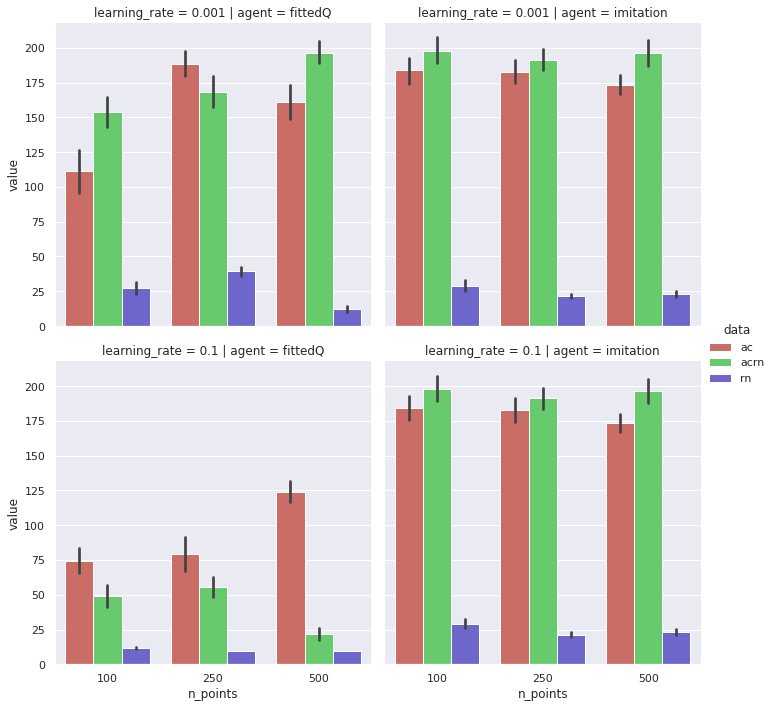

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

dfs = [pd.DataFrame(r) for r in results.values()]
df_fittedQ = pd.concat([pd.DataFrame(r) for r in results.values()])
df_fittedQ['n_points'] = df_fittedQ.index
df_fittedQ = df_fittedQ.reset_index(drop=True)
_len = int(len(df_fittedQ)/len(results.keys()))
df_fittedQ['data'] = np.repeat(list(results.keys()),_len)
df_fittedQ['agent'] = 'fittedQ'
df_fittedQ = df_fittedQ.explode([0.001, 0.1], ignore_index=True)
df_fittedQ = pd.melt(df_fittedQ, id_vars=['n_points','data','agent'],  value_vars=[0.001, 0.1], var_name='learning_rate')

df_imitation = pd.DataFrame(results_imitation)
df_imitation['n_points'] = df_imitation.index
df_imitation = df_imitation.reset_index(drop=True)
df_imitation['agent'] = 'imitation'
df_imitation = df_imitation.explode(['ac','acrn','rn'], ignore_index=True)
df_imitation = pd.melt(df_imitation, id_vars=['n_points','agent'], value_vars=['ac','acrn','rn'],var_name='data')
df1 = df_imitation.copy()
df2 = df_imitation.copy()
df1['learning_rate'] = 0.001
df2['learning_rate'] = 0.1
df_imitation = pd.concat([df1,df2]).reset_index(drop=True)

df = pd.concat([df_fittedQ, df_imitation]).reset_index(drop=True)

sns.set_theme()
plt.figure()
sns.catplot(data=df,x='n_points',y='value',hue='data', kind='bar', col='agent', palette='hls', row='learning_rate')

## Results with MLP

In [39]:
import torch
import numpy as np
import gym
import multiprocessing 
import gc

gc.collect()

class FCNetwork(torch.nn.Module):
    def __init__(self, env, layers=[20,20]):
        super(FCNetwork, self).__init__()
        dim_input = 40
        dim_output = 2
        net_layers = []

        dim = dim_input
        for i, layer_size in enumerate(layers):
            net_layers.append(torch.nn.Linear(dim, layer_size))
            net_layers.append(torch.nn.ReLU())
            dim = layer_size
        net_layers.append(torch.nn.Linear(dim, 1))
        net_layers.append(torch.nn.Sigmoid())
        self.layers = net_layers
        self.network = torch.nn.Sequential(*net_layers)

    def forward(self, states):
        states = torch.tensor(states).float()
        return self.network(states.cuda())


def fit(model, states, actions, step_size):
    optimizer = torch.optim.Adam(model.network.parameters(), lr=step_size)
    criterion = torch.nn.BCELoss()

    for epoch in range(100):
        for idx in np.array_split(np.arange(len(actions)),1):
            state, action = states[idx,:], actions[idx]
            action = torch.tensor([action]).T.cuda()
            pred_qvalues = model(state)
            loss = criterion(pred_qvalues, action.float())
            model.network.zero_grad()
            loss.backward()
            optimizer.step()

# run simple logistic imitation learning 
results_imitation = {}
NUM_ENVS = 100
env = gym.vector.make('CartPole-v1',new_step_api=True, num_envs=NUM_ENVS)

for agent, eps, states, actions, rewards, terminal in DataLoader().load():

    for step_size in (1e-3, 1e-2):
        if not agent in results_imitation:
            results_imitation[agent] = {}

        if not step_size in results_imitation[agent]:
            results_imitation[agent][step_size] = {}

        results_imitation[agent][step_size][eps] = []

        model = FCNetwork(env).cuda()
        fit(model, states, actions, step_size)

        state = env.reset()

        total_reward = np.zeros(NUM_ENVS)
        terminated_all = np.zeros(NUM_ENVS)
        while True:
            discrete_state = torch.stack([torch.tensor(discretize_state(i)) for i in state])
            action_probs = model(discrete_state)
            action = (action_probs>0.5).flatten()

            # Perform the action -> Get the reward and observe the next state
            state, reward, terminated, _, _ = env.step(action.long().cpu().detach().numpy())

            if terminated.any():
                terminated_all[terminated] = True

            # once an episode has terminated, we don't want to add its reward
            total_reward+=reward*(1-terminated_all)
            if terminated_all.all(): 
                results_imitation[agent][step_size][eps] = total_reward
                break

<ipython-input-39-c56c2a8fcbeb>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  states = torch.tensor(states).float()


In [51]:
from copy import deepcopy
import numpy as np
import itertools
import gym
import torch

class FCNetwork(torch.nn.Module):
  def __init__(self, env, layers=[20,20]):
    super(FCNetwork, self).__init__()
    dim_input = 40
    dim_output = 2
    net_layers = []

    dim = dim_input
    for i, layer_size in enumerate(layers):
      net_layers.append(torch.nn.Linear(dim, layer_size))
      net_layers.append(torch.nn.ReLU())
      dim = layer_size
    net_layers.append(torch.nn.Linear(dim, dim_output))
    self.layers = net_layers
    self.network = torch.nn.Sequential(*net_layers)

  def forward(self, states):
    states = torch.tensor(states).float()
    return self.network(states)


class Estimator:
    def __init__(self, env, discretizer, network, step_size):
        self.discretizer = discretizer
        self.network = network
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr=step_size)

    def predict(self, s, a=None):
        predictions = self.network(s)
        if a is not None:
            predictions=predictions[a]
        return predictions
            
    def update(self, action, state, target):
        pred_qvalues = self.network(state)
        pred_qvalues = pred_qvalues.gather(0, torch.tensor([action])).squeeze()
        loss = torch.mean((pred_qvalues - target)**2)
        self.network.zero_grad()
        loss.backward()
        self.optimizer.step()    

class QLearning:
    def __init__(self, env, estimator, gamma):
        self.env = deepcopy(env)
        self.estimator = deepcopy(estimator)
        self.gamma = gamma

    def run(self, k_steps, states, actions, rewards, terminal):    
        for t in range(k_steps):
            # start with new state each episode
            idx = np.random.choice(np.arange(len(states)))

            state = states[idx,:]
            action = actions[idx]
            reward = rewards[idx]
            next_state = None if terminal[idx] else states[idx+1, :]

            # get the based q values at the new state
            if next_state is not None:
                target_value = reward + self.gamma * torch.max(self.estimator.predict(next_state))
            else:
                target_value = torch.tensor(0)
            self.estimator.update(action, state, target_value)

                
K_STEPS = 10000
NUM_EPS = 100
env = gym.make('CartPole-v1', new_step_api=True)
results={}

for agent, eps, states, actions, rewards, terminal in DataLoader().load():

    for step_size in (1e-3, 1e-2):
        if not agent in results:
            results[agent] = {}

        if not step_size in results[agent]:
            results[agent][step_size] = {}

        results[agent][step_size][eps] = []

        network = FCNetwork(env)
        estimator = Estimator(env, discretize_state, network, step_size)
        model = QLearning(env, estimator, gamma=0.95)
        model.run(K_STEPS, states, actions, rewards, terminal)

        for i_episode in range(NUM_EPS):   
            state = env.reset()

            total_reward = 0
            while True:
                action_probs = model.estimator.predict(estimator.discretizer(state))
                action =  torch.argmax(action_probs)

                # Perform the action -> Get the reward and observe the next state
                state, reward, terminated, _, _ = env.step(int(action))

                total_reward+=reward
                if terminated: 
                    results[agent][step_size][eps].append(total_reward)
                    break

<Figure size 640x480 with 0 Axes>

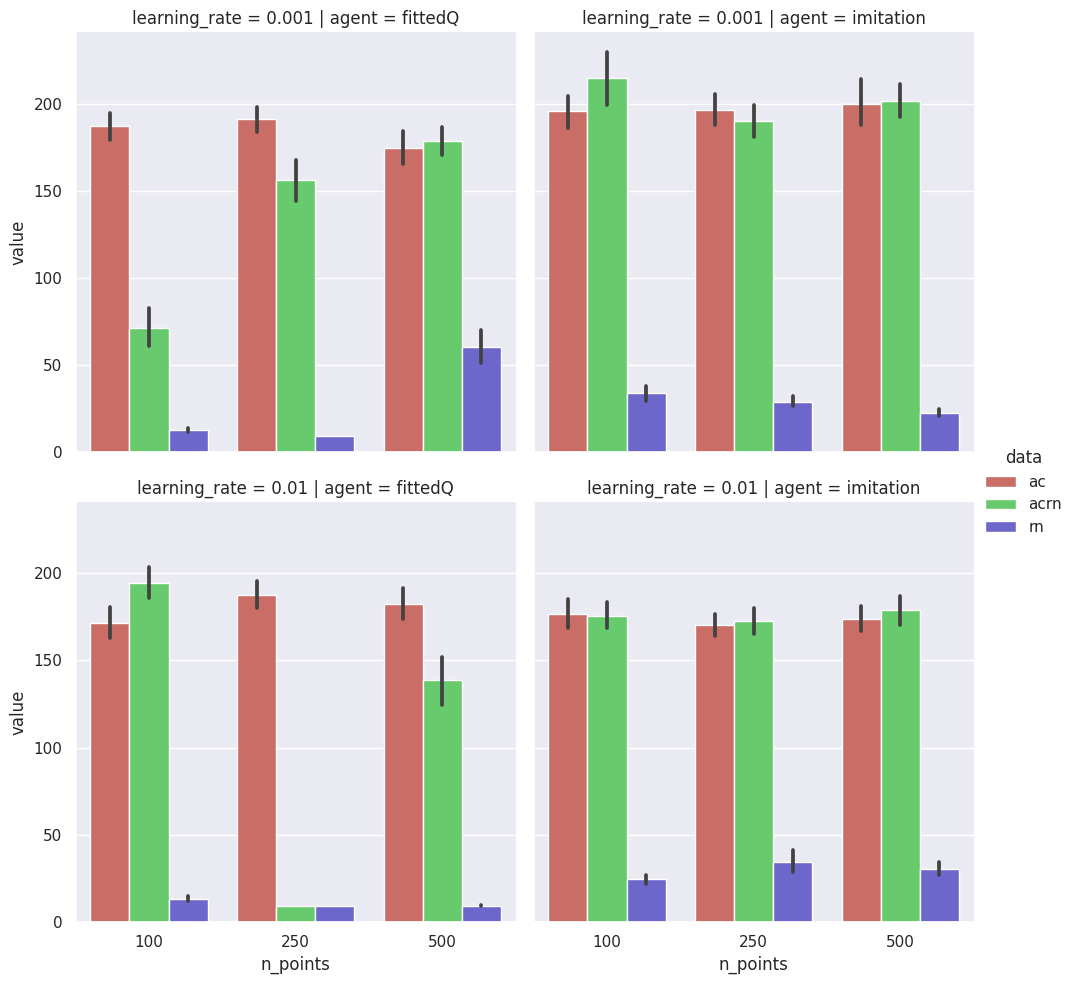

In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_fittedQ = pd.concat([pd.DataFrame(r) for r in results.values()])
df_fittedQ['n_points'] = df_fittedQ.index
df_fittedQ = df_fittedQ.reset_index(drop=True)
_len = int(len(df_fittedQ)/len(results.keys()))
df_fittedQ['data'] = np.repeat(list(results.keys()),_len)
df_fittedQ['agent'] = 'fittedQ'
df_fittedQ = df_fittedQ.explode([1e-3, 1e-2], ignore_index=True)
df_fittedQ = pd.melt(df_fittedQ, id_vars=['n_points','data','agent'],  value_vars=[1e-3, 1e-2], var_name='learning_rate')

df_imitation = pd.concat([pd.DataFrame(r) for r in results_imitation.values()])
df_imitation['n_points'] = df_imitation.index
df_imitation = df_imitation.reset_index(drop=True)
_len = int(len(df_imitation)/len(results_imitation.keys()))
df_imitation['data'] = np.repeat(list(results_imitation.keys()),_len)
df_imitation['agent'] = 'imitation'
df_imitation = df_imitation.explode([1e-3, 1e-2], ignore_index=True)
df_imitation = pd.melt(df_imitation, id_vars=['n_points','data','agent'],  value_vars=[1e-3, 1e-2], var_name='learning_rate')

df = pd.concat([df_fittedQ, df_imitation]).reset_index(drop=True)

sns.set_theme()
plt.figure()
sns.catplot(data=df,x='n_points',y='value',hue='data', kind='bar', col='agent', palette='hls', row='learning_rate')